<a href="https://colab.research.google.com/github/ethan060626/generative_ai/blob/main/week11_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

colab連結:[連結文字](https://colab.research.google.com/drive/1AoOFOZBe06qFugg4eUPmVxQK3YB5WF3J)

成果
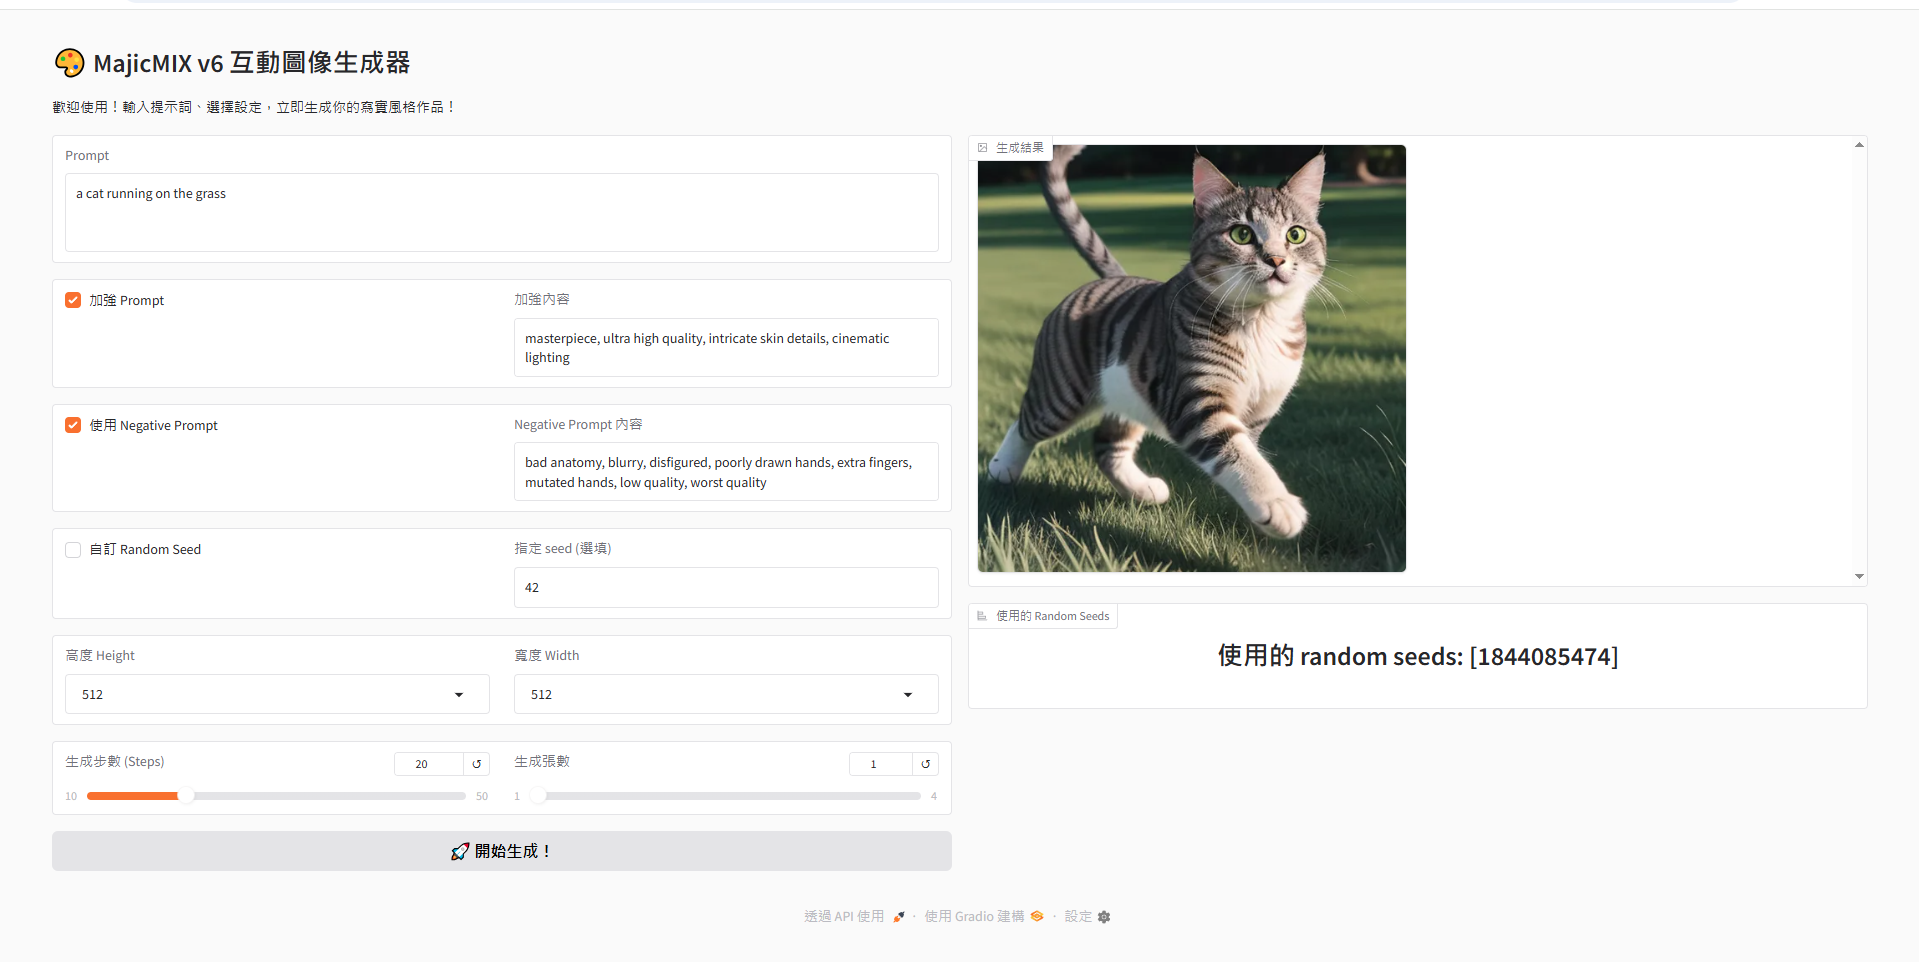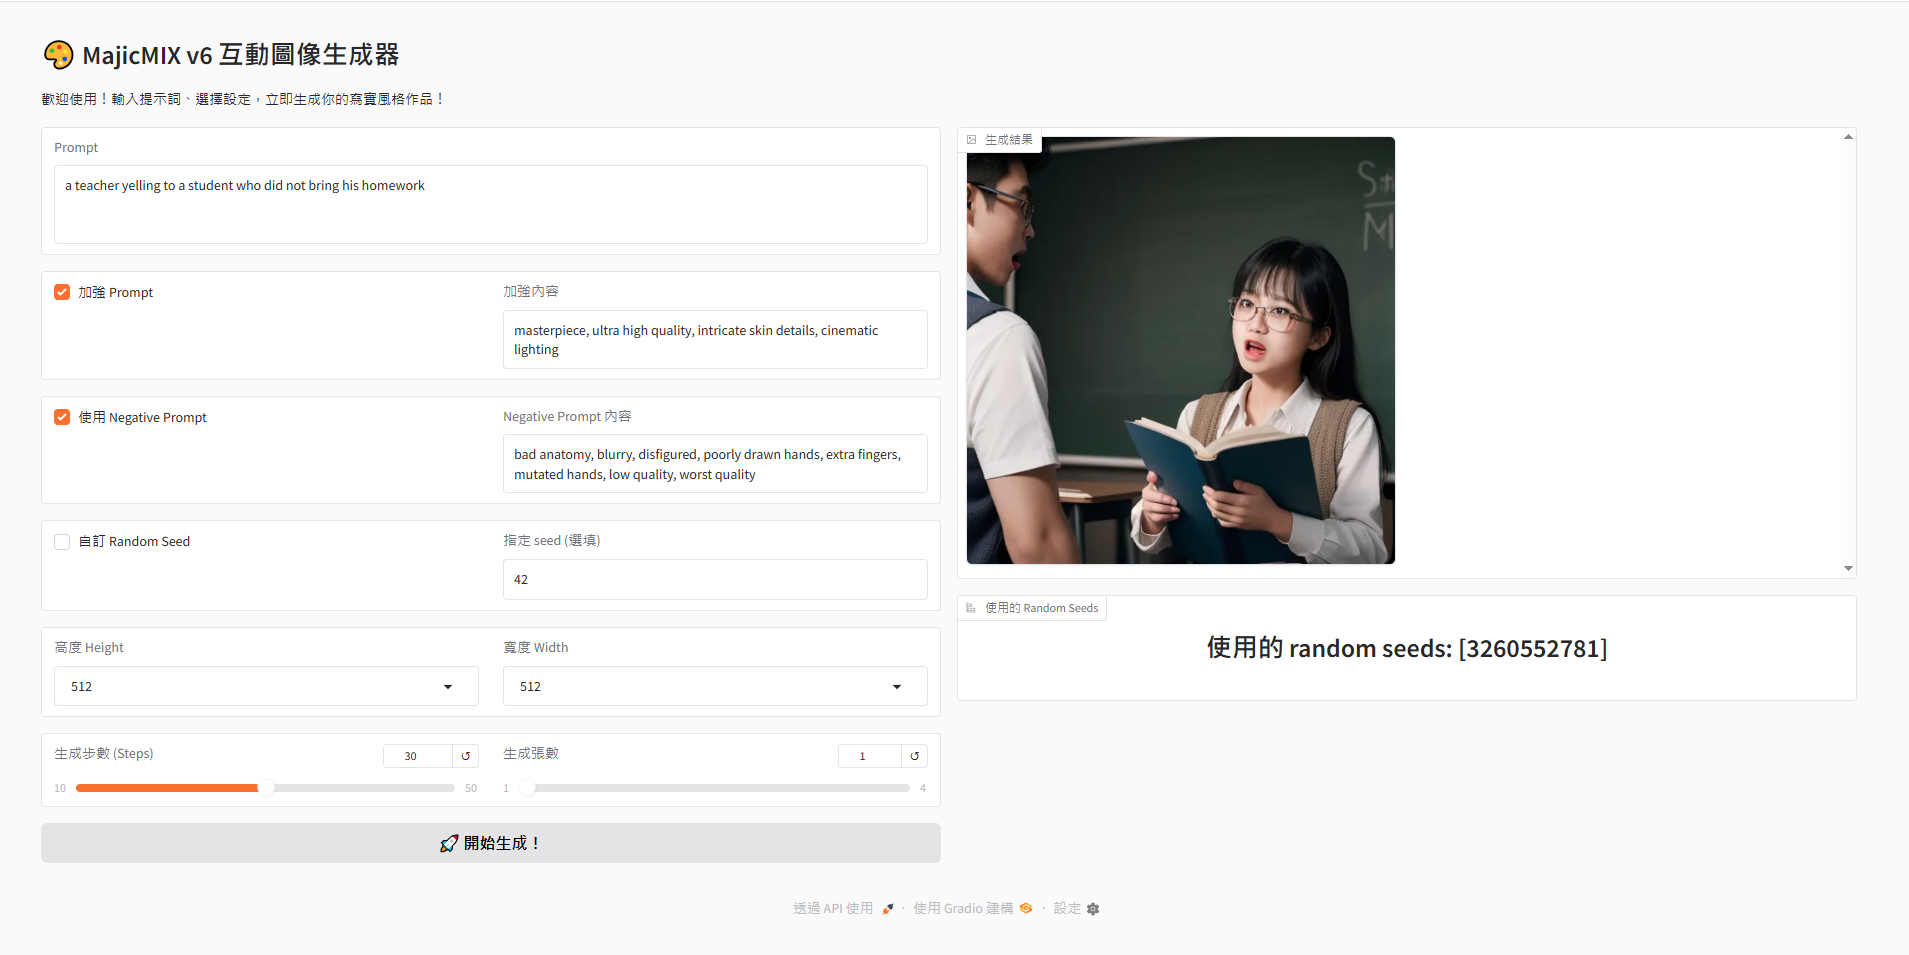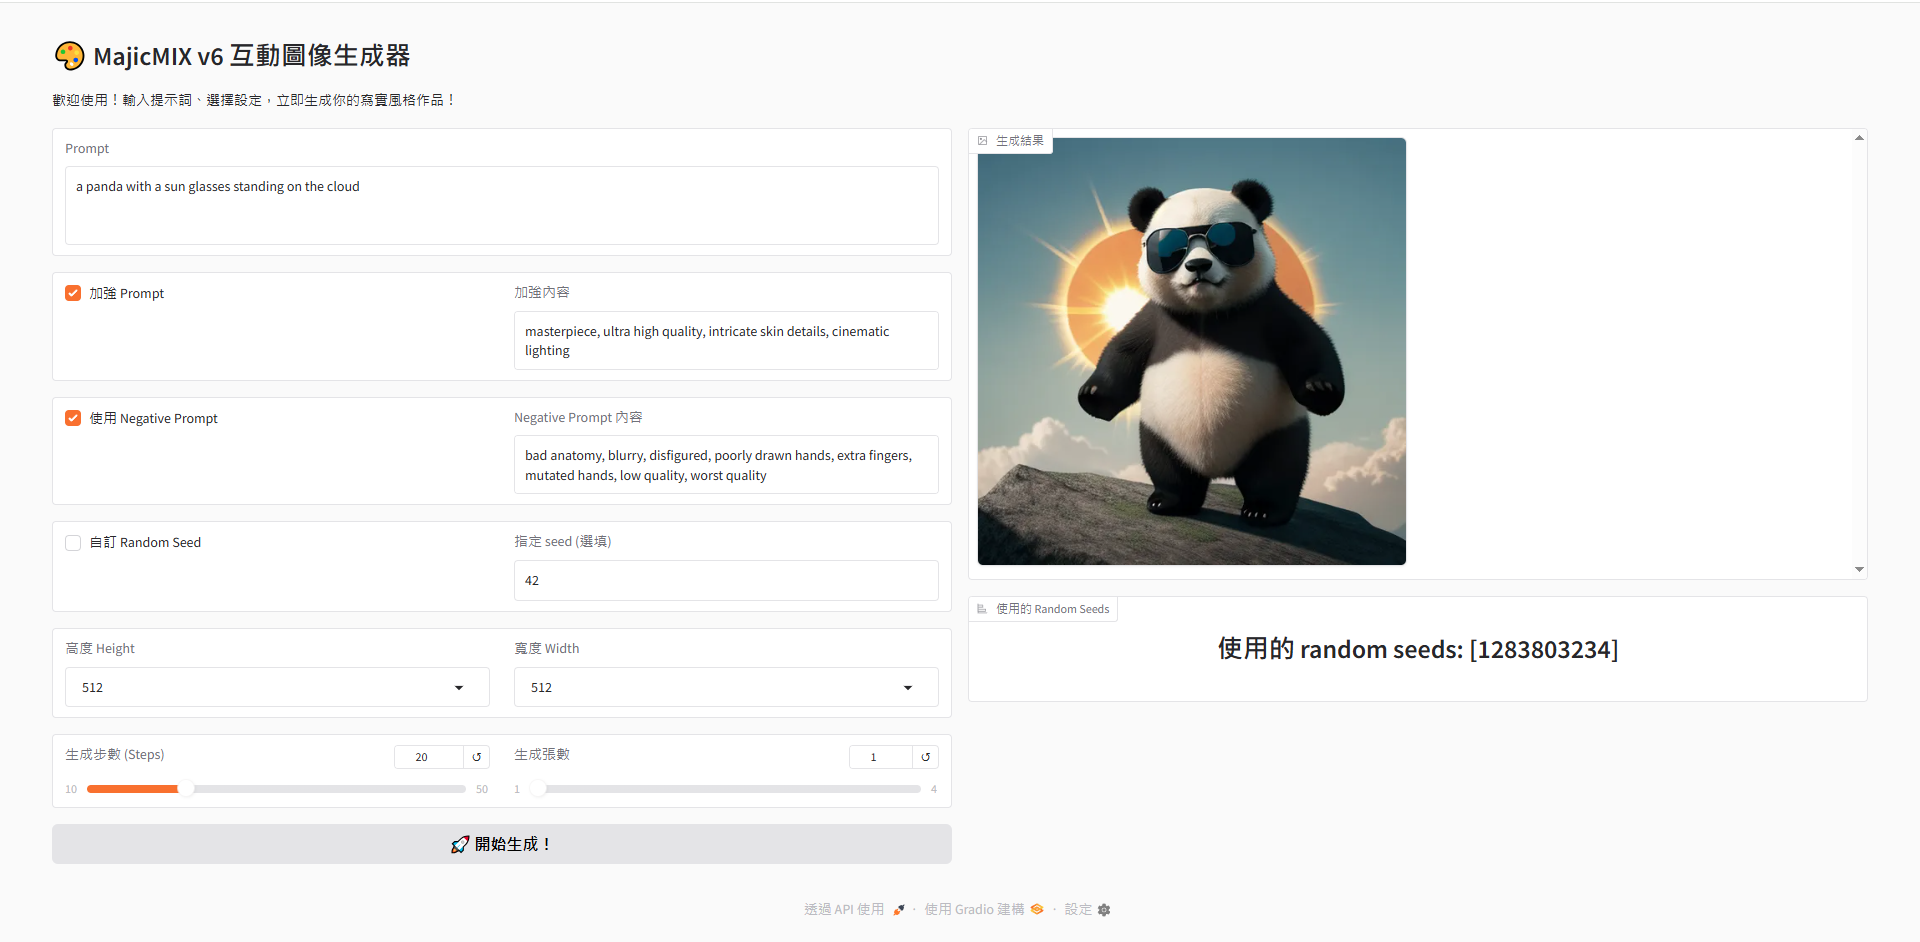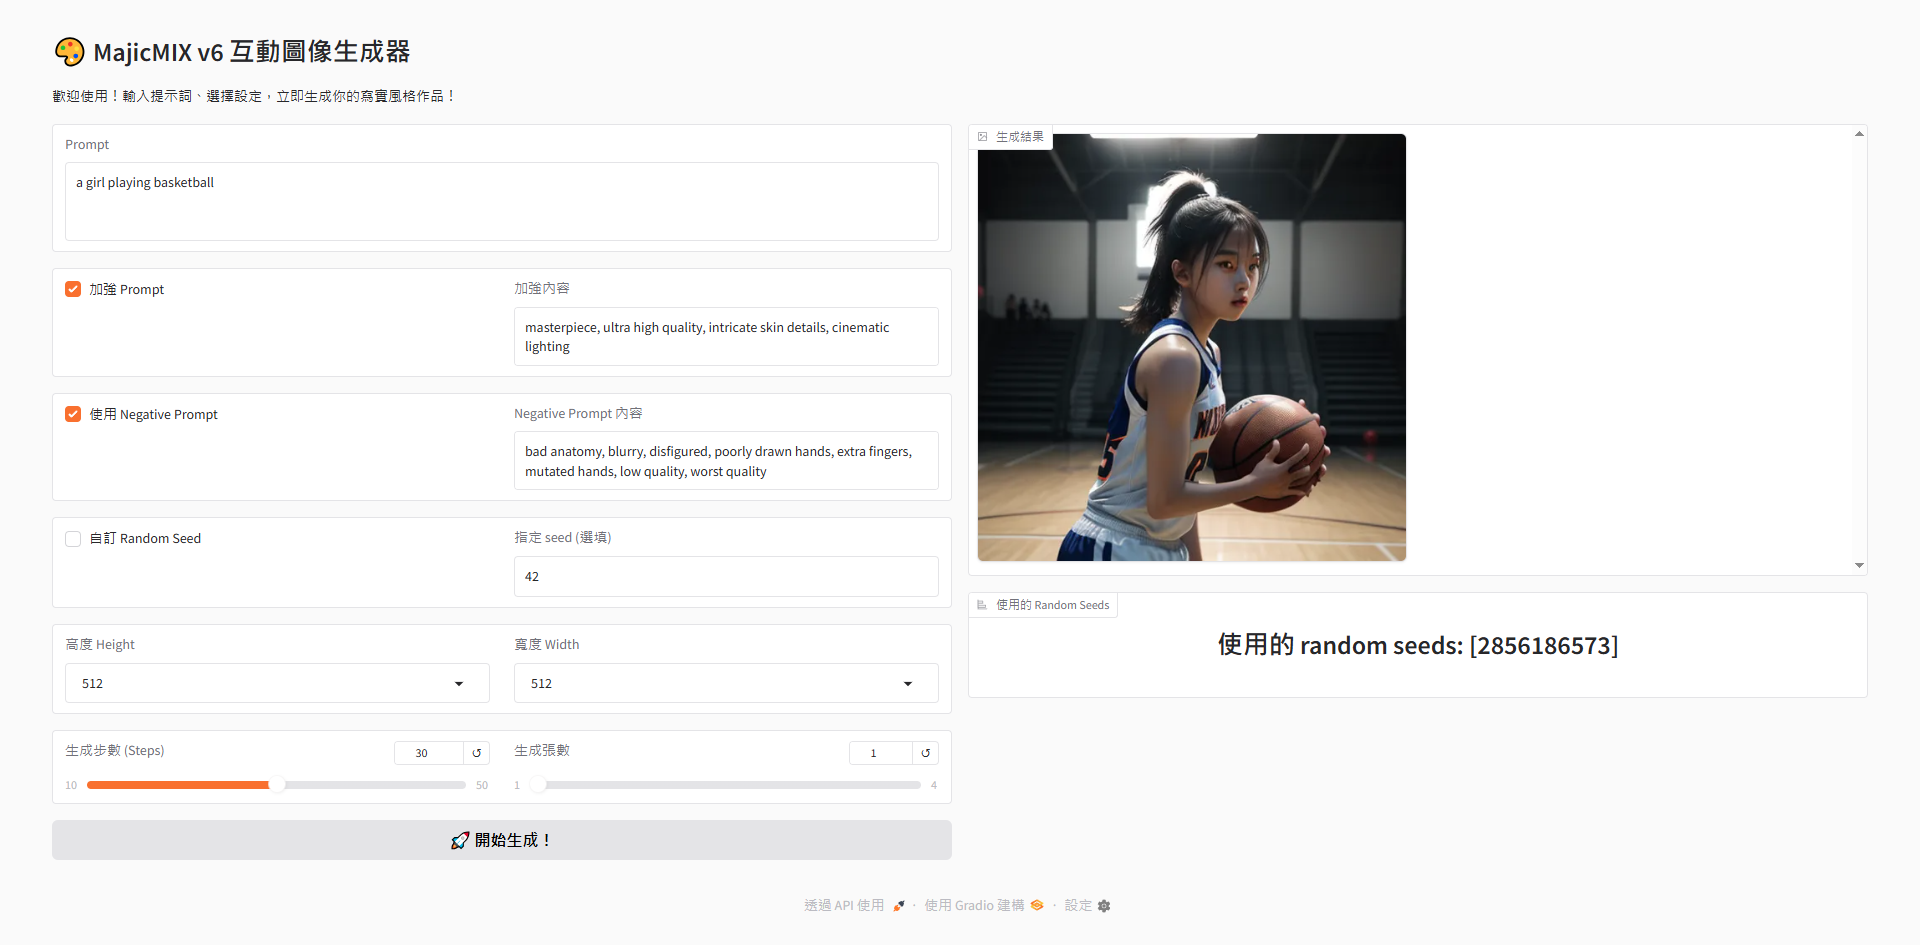